In [ ]:
!pip3 install catboost

     |████████████████████████████████| 65.7MB 46kB/s 


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
import gc
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm.notebook import tqdm
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn import model_selection
import lightgbm as lgbm
import warnings

warnings.filterwarnings('ignore')

np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
WORK_DIR = '/content/gdrive/MyDrive/Colab_Notebooks/DFC'
DATA_PATH = WORK_DIR + '/Data/'

In [ ]:
%%time
use_threads=False
df = pd.read_parquet(DATA_PATH + 'data_fusion_train.parquet')

CPU times: user 19.1 s, sys: 3.97 s, total: 23 s
Wall time: 32.1 s


One catboost

In [ ]:
def optimize_df(df):
  map_cols_to_type = {
    'category_id': np.int16,
    'item_nds_rate' : np.int16,
    'item_price' : np.int16,
    'item_quantity' : np.float32,
    'receipt_dayofweek' : np.int16,
    'receipt_id' : np.int32
  }
  for key in map_cols_to_type:
    df[key] = df[key].astype(map_cols_to_type[key])

  return df

In [ ]:
def create_features_about_mean_entity(df):
  gr_item_name = df.groupby('item_name')
  df['mean_item_quantity'] = gr_item_name['item_quantity'].transform("mean")
  df['sum_item_quantity'] = gr_item_name['item_quantity'].transform("sum")
  df['std_item_quantity'] = gr_item_name['item_quantity'].transform("std")
  df['min_item_quantity'] = gr_item_name['item_quantity'].transform("min")
  df['max_item_quantity'] = gr_item_name['item_quantity'].transform("max")

  df['mean_item_price'] = gr_item_name['item_price'].transform("mean")
  df['sum_item_price'] = gr_item_name['item_price'].transform("sum")
  df['std_item_price'] = gr_item_name['item_price'].transform("std")
  df['min_item_price'] = gr_item_name['item_price'].transform("min")
  df['max_item_price'] = gr_item_name['item_price'].transform("max")

  df['mean_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("mean")
  df['sum_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("sum")
  df['std_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("std")
  df['min_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("min")
  df['max_item_nds_rate'] = gr_item_name['item_nds_rate'].transform("max")


  df['hours'] = df['receipt_time'].apply(lambda x: int(x.split(":")[0]))

  df['mean_hours'] = gr_item_name['hours'].transform("mean")
  df['sum_hours'] = gr_item_name['hours'].transform("sum")
  df['std_hours'] = gr_item_name['hours'].transform("std")
  df['min_hours'] = gr_item_name['hours'].transform("min")
  df['max_hours'] = gr_item_name['hours'].transform("max")


  df['median_dayofweek'] = gr_item_name['receipt_dayofweek'].transform('median')
  df['median_dayofweek'] = df['median_dayofweek'].astype(np.int8)


  return df

In [ ]:
feature_names = ['receipt_id', 'receipt_dayofweek', 'receipt_time', 
                 'item_name', 'item_quantity', 'item_price', 'item_nds_rate', 
                 'mean_item_quantity', 'sum_item_quantity', 'std_item_quantity', 
                 'min_item_quantity', 'max_item_quantity', 'mean_item_price',
                 'sum_item_price', 'std_item_price', 'min_item_price',
                 'max_item_price', 'mean_item_nds_rate', 'sum_item_nds_rate', 
                 'std_item_nds_rate', 'min_item_nds_rate', 'max_item_nds_rate', 
                 'hours', 'mean_hours', 'sum_hours', 
                 'std_hours', 'min_hours', 'max_hours', 'median_dayofweek',
                 
                 'first',
                 'last', 'is_preservativ', 'is_paper', 'is_otkritka', 'is_born', 'is_a4', 'is_ubiley',                                         
                 'is_auto', 'is_list', 'is_kanc', 'is_dnevnik',
                
                'first_word_len', 'last_word_len',
                 'second_last_word', 'second_first_word',
                 
                 'last_first_word',
                ] 

cat_features = ['receipt_time', 'receipt_id', 'hours', 'min_hours', 'max_hours', 
                'median_dayofweek', 'first', 'last', 'second_last_word', 'second_first_word',
                 'last_first_word']
text_features = ['item_name']

target = 'category_id'


def create_features(data):
    data['first'] = data['item_name'].apply(lambda x: x.split()[0] if len(x.split()) > 0 else 'none')
    data['last'] = data['item_name'].apply(lambda x: x.split()[-1] if len(x.split()) > 0 else 'none')
    data['is_preservativ'] = data.item_name.apply(lambda x: int('презерватив' in x.lower()))
    data['is_auto'] = data.item_name.apply(lambda x: int('авто' in x.lower() or \
                                                            'щетк' in x.lower() or \
                                                             'сантиметр' in x.lower()))

    data['is_paper'] = data.item_name.apply(lambda x: int('бумага' in x.lower()))
    data['is_otkritka'] = data.item_name.apply(lambda x: int('открытка' in x.lower()))
    data['is_born'] = data.item_name.apply(lambda x: int('рождения' in x.lower()))
    data['is_a4'] = data.item_name.apply(lambda x: int('а4' in x.lower()))
    data['is_ubiley'] = data.item_name.apply(lambda x: int('юбиле' in x.lower()))

    #24
    data['is_list'] = data.item_name.apply(lambda x: int('лист' in x.lower()))
    data['is_kanc'] = data.item_name.apply(lambda x: int('канцелярский' in x.lower()))
    data['is_dnevnik'] = data.item_name.apply(lambda x: int('дневник' in x.lower()))
    
    data['second_last_word'] = data.item_name.apply(lambda x: x.split()[-2] if len(x.split()) > 1 else 'none')
    data['second_first_word'] = data.item_name.apply(lambda x: x.split()[1] if len(x.split()) > 1 else 'none')

    data['first_word_len'] = data['first'].apply(len)
    data['last_word_len'] = data['last'].apply(len)

    data['item_name_len'] = data.item_name.apply(lambda x: len(x.split()))

    data['last_first_word'] = data['last'] + data['first']
    return data


def fill_median(df):
    df['std_item_quantity'] = df['std_item_quantity'].fillna(np.nanmedian(df['std_item_quantity']))
    df['std_item_price'] = df['std_item_price'].fillna(np.nanmedian(df['std_item_price']))
    df['std_item_nds_rate'] = df['std_item_nds_rate'].fillna(np.nanmedian(df['std_item_nds_rate']))
    df['std_hours'] = df['std_hours'].fillna(np.nanmedian(df['std_hours']))
    return df

    

In [ ]:
# def string_transform(string):
#   mix_cat_words = []#['шт', 'ккал', 'л', 'кг', 'г']
#   string = string.split()
#   string = [word.lower() for word in string  if word not in mix_cat_words]
#   return ' '.join(string)

# def clear_text(text_series):
  
#   """Удаление всех символов, кроме букв в Series"""
#   text_series = text_series.fillna('')
#   text_series = text_series.str.replace(r'[\s]', ' ')
#   text_series = text_series.str.replace(r'[\W0-9]', ' ')
#   text_series = text_series.str.replace(r" {2,}", " ")

#   return text_series.apply(string_transform)


df = optimize_df(df)
df = create_features_about_mean_entity(df)

df = df[df['category_id'] != -1]
df_uni = df.drop_duplicates('item_name')
#df_uni['item_name'] = clear_text(df_uni['item_name'])

In [ ]:
df_uni['item_name']

1                                              Молоко 3,2%,шт
3                                   Компот из изюма, 114 ккал
4           Макаронные изделия отварные (масло сливочное),...
17                              Кофе Капучино Большой Эден 18
40                                     Хлеб на СЫВОРОТКЕ 350г
                                  ...                        
45669181                       Напиток Энерг. Ред Булл 0,355л
45681543                                    Хеменгуэй Дайкири
45690702      Пиво светлое "Халзан" 4,5 % об, пл/б. 1,5 л(шт)
45692298                                     Экспресс педикюр
45700308                 Конфеты Харитоша 1кг мол. ваф Яшкино
Name: item_name, Length: 48225, dtype: object

In [ ]:
!pip3 install razdel

In [ ]:
import pickle
from sklearn.metrics import classification_report
import nltk
import string
from nltk.tokenize import WordPunctTokenizer 
from razdel import tokenize
from nltk.corpus import stopwords

nltk.download('punkt', download_dir='nltk_models')
nltk.download('stopwords', download_dir='nltk_models')

!mkdir nltk_models
!pip3 install razdel
!git clone https://github.com/natasha/razdel.git

nltk.download('stopwords')
RU_STOP_WORDS = set(stopwords.words('russian'))
    
def pre_process(text):
    return " ".join([token.lower() for token in [_.text for _ in tokenize(text)]
                     if (token not in RU_STOP_WORDS) or (token not in string.punctuation)])

[nltk_data] Downloading package punkt to nltk_models...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to nltk_models...
[nltk_data]   Unzipping corpora/stopwords.zip.
mkdir: cannot create directory ‘nltk_models’: File exists
Cloning into 'razdel'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 505 (delta 88), reused 101 (delta 51), pack-reused 343
Receiving objects: 100% (505/505), 42.67 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (297/297), done.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_uni['item_name'] = df_uni['item_name'].apply(pre_process)
df = create_features(df)
df = fill_median(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6483226 entries, 1 to 45729281
Data columns (total 49 columns):
 #   Column              Dtype  
---  ------              -----  
 0   receipt_id          int32  
 1   receipt_dayofweek   int16  
 2   receipt_time        object 
 3   item_name           object 
 4   item_quantity       float32
 5   item_price          int16  
 6   item_nds_rate       int16  
 7   category_id         int16  
 8   brands              object 
 9   mean_item_quantity  float32
 10  sum_item_quantity   float32
 11  std_item_quantity   float64
 12  min_item_quantity   float32
 13  max_item_quantity   float32
 14  mean_item_price     float64
 15  sum_item_price      float64
 16  std_item_price      float64
 17  min_item_price      int16  
 18  max_item_price      int16  
 19  mean_item_nds_rate  float64
 20  sum_item_nds_rate   float64
 21  std_item_nds_rate   float64
 22  min_item_nds_rate   int16  
 23  max_item_nds_rate   int16  
 24  hours               int

# Usual train test split

In [ ]:
from sklearn.model_selection  import train_test_split

train, valid = model_selection.train_test_split(df_uni,
                                                test_size=0.10, 
                                                stratify=df_uni['category_id'], 
                                                shuffle=True, random_state=10)

In [ ]:
# train['item_name_tmp'] = train['item_name'].values
# valid['item_name_tmp'] = valid['item_name'].values

# train['item_name'] = train.item_name.apply(pre_process)
# valid['item_name'] = valid.item_name.apply(pre_process)

# train = create_features(train)
# valid = create_features(valid)

# train = fill_median(train)
# valid = fill_median(valid)

#Catboost Model

In [ ]:
def get_catboost_model(cat_features, text_features):
#   best_params={'bagging_temperature': 0.41010395885331385,
#  'border_count': 186,
#  'depth': 5,
#  'iterations': 1000,
#  'l2_leaf_reg': 21,
#  #'learning_rate': 0.1#0.0673344419215237,
#  'random_strength': 3.230824361824754e-06,
#  }

  model = CatBoostClassifier(
      #**best_params,
      cat_features=cat_features,
      text_features=text_features,
      verbose=50,
      loss_function='MultiClass',
      eval_metric='TotalF1',
      task_type="GPU",
      iterations=1000,#1000,
      learning_rate=0.5,      
      # reg_lambda=0.0001,
      
      text_processing = {
          "tokenizers" : [{
              "tokenizer_id" : "Space",
              "separator_type" : "ByDelimiter",
              "delimiter" : " "
          }],

          "dictionaries" : [{
              "dictionary_id" : "BiGram",
              "token_level_type": "Letter",
              "max_dictionary_size" : "150000",
              "occurrence_lower_bound" : "1",
              "gram_order" : "2"
          },{
              "dictionary_id" : "Trigram",
              "max_dictionary_size" : "150000",
              "token_level_type": "Letter",
              "occurrence_lower_bound" : "1",
              "gram_order" : "3"
          },{
              "dictionary_id" : "Fourgram",
              "max_dictionary_size" : "150000",
              "token_level_type": "Letter",
              "occurrence_lower_bound" : "1",
              "gram_order" : "4"
          },{
              "dictionary_id" : "Fivegram",
              "max_dictionary_size" : "150000",
              "token_level_type": "Letter",
              "occurrence_lower_bound" : "1",
              "gram_order" : "5"
          },{
              "dictionary_id" : "Sixgram",
              "max_dictionary_size" : "150000",
              "token_level_type": "Letter",
              "occurrence_lower_bound" : "1",
              "gram_order" : "6"
          }
          ],

          "feature_processing" : {
              "default" : [
                      {
                      "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                      "feature_calcers" : ["BoW"],
                      "tokenizers_names" : ["Space"]
                  },
                      {
                  "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                  "feature_calcers" : ["NaiveBayes"],
                  "tokenizers_names" : ["Space"]
              },{
                  "dictionaries_names" : [ "BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                  "feature_calcers" : ["BM25"],
                  "tokenizers_names" : ["Space"]
              },
              ],
          }
      }
    )

  return model



### Experimental Catboost run

In [ ]:
model = get_catboost_model(cat_features, text_features)
history = model.fit(
    df[feature_names], df[target],
    # eval_set=(valid[feature_names], valid[target]),
)

## Usual catboost

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import GPUtil as GPU
GPUs = GPU.getGPUs()
print(GPUs)
gpu = GPUs[0]
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# assert gpu.memoryFree > 12000

In [ ]:
model = get_catboost_model(cat_features, text_features)
history = model.fit(
    train[feature_names], train[target],
    eval_set=(valid[feature_names], valid[target]),
)

In [ ]:
model.get_feature_importance(prettified=True)

# Model Training and Evualating

In [ ]:
from sklearn.metrics import f1_score

### Model loading

In [ ]:
with open('/content/gdrive/MyDrive/Colab_Notebooks/DFC/Models/' + "catboost.clf", 'rb') as fout:
    clf = pickle.loads(fout.read())

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

feature_importance_df = pd.DataFrame(clf.get_feature_importance(prettified=True))

In [ ]:
feature_importance_df.columns

Index(['Feature Id', 'Importances'], dtype='object')

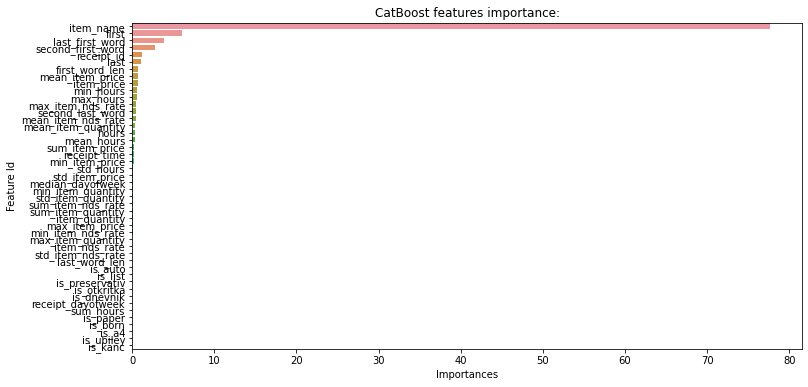

In [ ]:
plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=feature_importance_df);
plt.title('CatBoost features importance:');

In [ ]:
f1_score(valid[target], clf.predict(valid[feature_names]), average='weighted')

0.818674744356778

In [ ]:
f1_score(valid[target], clf.predict_proba(valid[feature_names]).argmax(axis=1), average='weighted')

0.056980434014750336

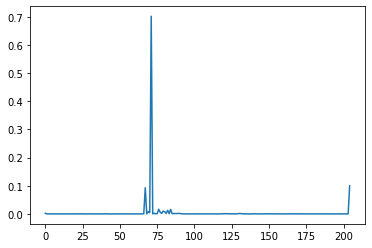

In [ ]:
pd.DataFrame(clf.predict_proba(valid[feature_names]), columns=clf.classes_).loc[0].plot()

In [ ]:
valid[target].reset_index().loc[0]

index          12308819
category_id          67
Name: 0, dtype: int64

In [ ]:
clf.predict(valid[feature_names])[0]

array([71])

In [ ]:
pd.DataFrame(clf.predict_proba(valid[feature_names]), columns=clf.classes_).loc[0][67]

0.0928257970514921

In [ ]:
pd.DataFrame(clf.predict_proba(valid[feature_names]), columns=clf.classes_).loc[0].max()

0.7018380946886654

In [ ]:
pd.DataFrame(clf.predict_proba(valid[feature_names]), columns=clf.classes_).loc[0].argmax()

48

In [ ]:
clf.classes_[48]

71

In [ ]:
check_preds = [clf.classes_[cat] for cat in clf.predict_proba(valid[feature_names]).argmax(axis=1)]

In [ ]:
f1_score(valid[target], check_preds, average='weighted')

0.818674744356778

In [ ]:
predictions = ( 0.9 * clf.predict_proba(valid[feature_names]) + 0.2 * clf.predict_proba(valid[feature_names]) ) / 2.0
check_predictions = [clf.classes_[cat] for cat in predictions.argmax(axis=1)]
f1_score(valid[target], check_predictions, average='weighted')

0.818674744356778

In [ ]:
# preds = clf.predict_proba(valid[feature_names])
# preds = (preds + preds) / 2
# preds.argmax(axis=1)

# pd.get_dummies(preds.argmax(axis=1))

Simple ensemble

In [ ]:
num_ensembles = 2 #5
y_pred = 0.0
for i in tqdm(range(num_ensembles)):
    # TODO(you): Use CV, tune hyperparameters
    model = get_catboost_model(cat_features, text_features)
    history = model.fit(
        train[feature_names], train[target],
        eval_set=(valid[feature_names], valid[target]),
    )
    y_pred += model.predict_proba(valid[feature_names])
y_pred /= num_ensembles

0:	learn: 0.1753661	test: 0.1824299	best: 0.1824299 (0)	total: 1.43s	remaining: 13m 4s
50:	learn: 0.7365318	test: 0.7686276	best: 0.7686276 (50)	total: 1m 7s	remaining: 11m 4s
100:	learn: 0.7648716	test: 0.7876903	best: 0.7879174 (99)	total: 2m 10s	remaining: 9m 38s
150:	learn: 0.7869397	test: 0.7968167	best: 0.7972429 (136)	total: 3m 17s	remaining: 8m 40s
200:	learn: 0.8043147	test: 0.8011652	best: 0.8018126 (198)	total: 4m 23s	remaining: 7m 36s
250:	learn: 0.8185283	test: 0.8068102	best: 0.8069672 (249)	total: 5m 27s	remaining: 6m 30s
300:	learn: 0.8317457	test: 0.8098689	best: 0.8108305 (299)	total: 6m 30s	remaining: 5m 22s
350:	learn: 0.8423068	test: 0.8087512	best: 0.8108305 (299)	total: 7m 31s	remaining: 4m 16s
400:	learn: 0.8528740	test: 0.8112619	best: 0.8114426 (397)	total: 8m 33s	remaining: 3m 10s
450:	learn: 0.8624228	test: 0.8113850	best: 0.8118228 (415)	total: 9m 33s	remaining: 2m 5s
500:	learn: 0.8713137	test: 0.8121137	best: 0.8132477 (477)	total: 10m 33s	remaining: 1m 1

In [ ]:
y_pred

array([[2.54711460e-03, 4.46008181e-06, 5.25134676e-04, ...,
        2.77888909e-04, 1.58748495e-04, 1.22171343e-01],
       [1.44516393e-05, 2.92733358e-07, 6.49911236e-06, ...,
        2.68545500e-06, 6.07150380e-06, 9.07532016e-04],
       [1.56601253e-03, 2.55125423e-05, 5.57399842e-03, ...,
        5.06900427e-04, 3.71437063e-03, 3.98332558e-01],
       ...,
       [4.44526533e-05, 6.44139581e-05, 1.51372108e-04, ...,
        5.41506492e-03, 6.70172356e-04, 7.37372592e-03],
       [1.05109669e-02, 1.00301251e-03, 1.42829041e-03, ...,
        4.68247904e-03, 9.52220586e-05, 2.50249611e-02],
       [4.14420073e-04, 3.75359564e-04, 3.47161057e-04, ...,
        6.32646922e-05, 2.58950804e-04, 5.13491877e-03]])

In [ ]:
check_predictions = [clf.classes_[cat] for cat in y_pred.argmax(axis=1)]
f1_score(valid[target], check_predictions, average='weighted')

0.8116086485480347